This code performs the prediction of litho clusters for the unknown wells and assignment the common statistics for porosity and permeability within each cluster.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install mgwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 16.7 MB/s eta 0:00:00


In [3]:
#Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [4]:
import matplotlib.patches as mpatches

# This function plots well logs along with any zone column like lithology or stratigraphy.
# To ensure the consistent coloring you should specify the number of classes prior to calling the function,
# for example:
# litho _classes = [0,1,2,3,4,5,6]
# plot_logs_and_litho(df,"Well_name","Depth",['AC','SP','GR', 'NPHI'],["Strat_zone"], litho_classes=lithology_classes)

def plot_logs_and_litho(df, well_column, depth_column, log_columns, lithology_columns):

    # Define colors for lithology classes for each column
    lithology_maps = {}
    for lithology_column in lithology_columns:
        lithology_classes = df[lithology_column].unique()
        lithology_maps[lithology_column] = {lith: color for lith, color in zip(lithology_classes, plt.cm.tab20.colors)}

    # Group the DataFrame by the well column
    grouped = df.groupby(well_column)

    # Iterate over each well group
    for well, data in grouped:
        # Create subplots: logs + lithology strips for each lithology column
        n_cols = len(log_columns) + len(lithology_columns)
        fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(15, 8), sharey=True)
        fig.suptitle(f"Well Logs for {well}", fontsize=16)

        # Plot each log
        for i, log in enumerate(log_columns):
            axes[i].plot(data[log], data[depth_column], label=log)
            axes[i].invert_yaxis()  # Depth typically increases downward
            axes[i].set_xlabel(log)
            axes[i].set_ylabel("Depth" if i == 0 else "")
            axes[i].grid(True)
            axes[i].legend()

        # Plot each lithology column
        for j, lithology_column in enumerate(lithology_columns):
            lith_ax = axes[len(log_columns) + j]
            lith_ax.set_title(lithology_column)
            lith_ax.set_xlim(0, 1)
            lith_ax.set_xticks([])
            lith_ax.set_xlabel("Classes")

            lith_map = lithology_maps[lithology_column]

            for lith in lith_map:
                lith_data = data[data[lithology_column] == lith]
                lith_ax.fill_betweenx(
                    lith_data[depth_column], 0, 1,
                    color=lith_map[lith], label=lith, alpha=0.8
                )

            #lith_ax.invert_yaxis()  # Match depth axis direction

            # Add a legend for the lithology column
            patches = [mpatches.Patch(color=lith_map[lith], label=lith) for lith in lith_map]
            lith_ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.3, 1))

        # Adjust layout and show plot
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
        plt.show()

In [ ]:
# Optional Function to process the litho column by eliminating the intervals of thickness less than 1m.
# Depending on the task and input data we might want to reduse the presition of detected litho intervals.
# Based on the threshold the intervals that are too thin are eliminated and interpolated from the above and below.

def process_litho(df):
    # Identify the start and end of each litho class segment
    df['litho_change'] = df['Litho'].ne(df['Litho'].shift())
    df['segment_id'] = df['litho_change'].cumsum()

    # Calculate the length of each segment
    segment_lengths = df.groupby('segment_id')['Depth'].transform('count')

    # Identify segments that are less than 1 meter
    short_segments = segment_lengths < 10

    # Replace short segments with NaN
    df.loc[short_segments, 'Litho'] = pd.NA

    # Forward and backward fill the NaN values
    df['Litho'] = df['Litho'].ffill().bfill()

    # Drop the helper columns
    df.drop(columns=['litho_change', 'segment_id'], inplace=True)

    return df

# 1. Prepare the data frame for known wells

In [5]:
#Load the data frame with clusters for known wells
df_init = pd.read_csv("/content/Litho_clusters.csv")

In [6]:
df_init

,Unnamed: 0,Depth,Well_name,Surface_number,SP,AC,GR,RHOB,NPHI,VSHALE,PHIT,PERM,KMeans,GMM_20
0,1509,150.9,LONCCARICA-1,1,35.807999,NaN,45.079273,2.295228,39.358006,NaN,NaN,NaN,9,5
1,1510,151.0,LONCCARICA-1,1,36.264999,NaN,42.390808,2.295228,39.358006,NaN,NaN,NaN,9,5
2,1511,151.1,LONCCARICA-1,1,36.833000,NaN,42.390808,2.295228,39.358006,NaN,NaN,NaN,9,5
3,1512,151.2,LONCCARICA-1,1,37.355000,NaN,42.390808,2.295228,39.358006,NaN,NaN,NaN,9,5
4,1513,151.3,LONCCARICA-1,1,37.755001,NaN,42.390808,2.295228,39.358006,NaN,NaN,NaN,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202773,213131,3738.6,VIROVITICA-3ALFA,6,47.029999,57.389999,42.110001,2.763000,4.700000,0.693509,0.153693,0.007883,4,9
202774,213132,3738.7,VIROVITICA-3ALFA,6,46.619999,56.480000,39.118999,2.769000,4.363000,0.653299,0.147841,0.008116,4,9
202775,213133,3738.8,VIROVITICA-3ALFA,6,46.209999,55.900002,36.377998,2.777000,4.063000,0.613089,0.144111,0.010106,4,9
202776,213134,3738.9,VIROVITICA-3ALFA,6,45.799999,55.669998,34.375999,2.787000,3.799000,0.572878,0.142632,0.014979,4,9


In [7]:
#Check that all the wells are preserved
Well_names = df_init["Well_name"].unique().tolist()

In [8]:
# Rename the Litho column
df_init["Litho"]=df_init["KMeans"]

In [10]:
# Process the DataFrame
df_processed = process_litho(df_init)

In [11]:
wells_location = {"Well_name":["REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1","VIROVITICA-1","VIROVITICA-3ALFA", "LONCCARICA-1", "Unkown-1", "Unkown-2"],
                  "X":[689340.71,688872.79,693135.92,685448.76,686218.75,680935.09,683447.00, 691636.00],
                  "Y":[5072557.33,5073318.89,5073660.97,5073267.09,5073539.22,5070578.64,5072765.00,5072723.00],
                  "TD": [3312.0,4554.0,4987.5,2956.5,4087.0,1764.0,2034.0,5435.0]
                  }

wells_location = pd.DataFrame(wells_location)

In [12]:
known_wells = wells_location[~wells_location['Well_name'].isin(['Unkown-1', 'Unkown-2'])]
unknown_wells = wells_location[wells_location['Well_name'].isin(['Unkown-1', 'Unkown-2'])]

In [ ]:
#Merge the data for known wells
df_merged = pd.merge(df_processed, known_wells, on='Well_name', how='inner')
df_merged = df_merged[['Depth', 'Well_name', 'Surface_number', 'X', 'Y', 'Litho']]

In [15]:
df_merged

,Depth,Well_name,Surface_number,X,Y,Litho
0,150.9,LONCCARICA-1,1,680935.09,5070578.64,9.0
1,151.0,LONCCARICA-1,1,680935.09,5070578.64,9.0
2,151.1,LONCCARICA-1,1,680935.09,5070578.64,9.0
3,151.2,LONCCARICA-1,1,680935.09,5070578.64,9.0
4,151.3,LONCCARICA-1,1,680935.09,5070578.64,9.0
...,...,...,...,...,...,...
202773,3738.6,VIROVITICA-3ALFA,6,686218.75,5073539.22,0.0
202774,3738.7,VIROVITICA-3ALFA,6,686218.75,5073539.22,0.0
202775,3738.8,VIROVITICA-3ALFA,6,686218.75,5073539.22,0.0
202776,3738.9,VIROVITICA-3ALFA,6,686218.75,5073539.22,0.0


# 2. Prepare the dataframe for unknown wells

In [16]:
unknown_wells

,Well_name,X,Y,TD
6,Unkown-1,683447.0,5072765.0,2034.0
7,Unkown-2,691636.0,5072723.0,5435.0


In [17]:
# Initialize an empty list to store the expanded data
expanded_data = []

# Loop over each well in the DataFrame
for _, row in unknown_wells.iterrows():
    well_name = row['Well_name']
    x = row['X']
    y = row['Y']
    max_depth = row['TD']

    # Generate depth values from 0 to max_depth with a step of 0.1 m
    depth_values = np.arange(100, max_depth + 0.1, 0.1)  # Include max_depth

    # Create a DataFrame for this well
    well_df = pd.DataFrame({
        'Well_name': well_name,
        'X': x,
        'Y': y,
        'Depth': depth_values
    })

    # Append the DataFrame to the list
    expanded_data.append(well_df)

# Concatenate all the DataFrames into a single DataFrame
unknown_df = pd.concat(expanded_data, ignore_index=True)

In [18]:
unknown_df

,Well_name,X,Y,Depth
0,Unkown-1,683447.0,5072765.0,100.0
1,Unkown-1,683447.0,5072765.0,100.1
2,Unkown-1,683447.0,5072765.0,100.2
3,Unkown-1,683447.0,5072765.0,100.3
4,Unkown-1,683447.0,5072765.0,100.4
...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6
72688,Unkown-2,691636.0,5072723.0,5434.7
72689,Unkown-2,691636.0,5072723.0,5434.8
72690,Unkown-2,691636.0,5072723.0,5434.9


In [19]:
Unknown_1 = unknown_df[unknown_df["Well_name"]== "Unkown-1"]
Unknown_2 = unknown_df[unknown_df["Well_name"]== "Unkown-2"]

In [20]:
Unknown_2

,Well_name,X,Y,Depth
19341,Unkown-2,691636.0,5072723.0,100.0
19342,Unkown-2,691636.0,5072723.0,100.1
19343,Unkown-2,691636.0,5072723.0,100.2
19344,Unkown-2,691636.0,5072723.0,100.3
19345,Unkown-2,691636.0,5072723.0,100.4
...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6
72688,Unkown-2,691636.0,5072723.0,5434.7
72689,Unkown-2,691636.0,5072723.0,5434.8
72690,Unkown-2,691636.0,5072723.0,5434.9


In [21]:
#Load well markers
well_markers = pd.read_csv("/content/Well_Markers.txt", delimiter='\t')

In [22]:
# Insert a numerical encoding for the formation names
well_markers['Surface_number'] = pd.factorize(well_markers['Surface'])[0]
print(well_markers.head(7))

      Well_name               Surface       MD  Surface_number
0  LONCCARICA-1  Lonja Sir. Ploje fm.     0.85               0
1  LONCCARICA-1        Bilogorska fm.   150.93               1
2  LONCCARICA-1       Bregi Sandstone   389.56               2
3  LONCCARICA-1            Moslavacks   520.81               3
4  LONCCARICA-1        Ivanic Grad fm  1102.42               4
5  LONCCARICA-1    Prkos i Precec fm.  1488.00               5
6  LONCCARICA-1   Moslavacka gora fm.  1598.67               6


In [23]:
well_markers["MD"] = well_markers["MD"].round(1)

In [24]:
markers_Unknown1 = well_markers[well_markers['Well_name'] == 'Unkown-1']
markers_Unknown2 = well_markers[well_markers['Well_name'] == 'Unkown--2']

In [26]:
markers_Unknown1["Top"] = markers_Unknown1["MD"]
markers_Unknown1["Bottom"]= markers_Unknown1["MD"].shift(-1)

markers_Unknown2["Top"] = markers_Unknown2["MD"]
markers_Unknown2["Bottom"]= markers_Unknown2["MD"].shift(-1)

markers_Unknown1["Bottom"] = markers_Unknown1["Bottom"].fillna(2034)
markers_Unknown2["Bottom"] = markers_Unknown2["Bottom"].fillna(5435)

<ipython-input-26-4ab9e64ecc31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  markers_Unknown1["Top"] = markers_Unknown1["MD"]
<ipython-input-26-4ab9e64ecc31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  markers_Unknown1["Bottom"]= markers_Unknown1["MD"].shift(-1)
<ipython-input-26-4ab9e64ecc31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [29]:
# Function to assign zones to the logs based on depth
def assign_zones(logs, tops):
    logs['Surface_number'] = None  # Initialize zone_name column
    for _, row in tops.iterrows():
        # Check if depth falls within the range [Top, Bottom) for the current zone
        condition = (logs['Depth'] >= row['Top']) & (logs['Depth'] < row['Bottom'])
        logs.loc[condition, 'Surface_number'] = row['Surface_number']
    return logs

In [30]:
# Assign zones to Unknown wells
Unknown_2_df = assign_zones(Unknown_2, markers_Unknown2)
Unknown_1_df = assign_zones(Unknown_1, markers_Unknown1)

<ipython-input-29-c1f8eab33b64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['Surface_number'] = None  # Initialize zone_name column


In [34]:
Unknown_df = pd.concat([Unknown_1_df, Unknown_2_df], axis=0, ignore_index=True)

In [35]:
Unknown_df

,Well_name,X,Y,Depth,Surface_number
0,Unkown-1,683447.0,5072765.0,100.0,0
1,Unkown-1,683447.0,5072765.0,100.1,0
2,Unkown-1,683447.0,5072765.0,100.2,0
3,Unkown-1,683447.0,5072765.0,100.3,0
4,Unkown-1,683447.0,5072765.0,100.4,0
...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,6
72688,Unkown-2,691636.0,5072723.0,5434.7,6
72689,Unkown-2,691636.0,5072723.0,5434.8,6
72690,Unkown-2,691636.0,5072723.0,5434.9,6


In [36]:
Unknown_df.to_csv("Unknown_df.csv")



---



# 3. Train the KNN classifyer

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

In [38]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[['Depth', 'X', 'Y', 'Surface_number']])
X_test_scaled = scaler.transform(Unknown_df[['Depth', 'X', 'Y', 'Surface_number']])

# Train K-Nearest Neighbors Model with weighted distance
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_scaled, df_merged['Litho'])

# Predict for Unknown Wells
predicted_clusters = knn.predict(X_test_scaled)

# Add Predictions to Unknown Wells DataFrame
Unknown_df["Predicted_Litho_cluster"] = predicted_clusters

In [39]:
# Function to enforce minimum interval length
def enforce_min_interval(df, column, min_length=10):
    """
    Enforces a minimum length for consecutive identical values in a column.

    Args:
        df (pd.DataFrame): DataFrame containing the column to process.
        column (str): Name of the column with class predictions.
        min_length (int): Minimum length of consecutive identical values.

    Returns:
        pd.Series: Smoothed column with enforced intervals.
    """
    values = df[column].values
    lengths = []  # Store run lengths
    start = 0  # Start index of the current run

    # Iterate through the column and calculate lengths of runs
    for i in range(1, len(values)):
        if values[i] != values[start]:
            lengths.append((start, i - start, values[start]))
            start = i
    # Add the final run
    lengths.append((start, len(values) - start, values[start]))

    # Modify runs shorter than the minimum length
    smoothed_values = values.copy()
    for start, length, value in lengths:
        if length < min_length:
            # Merge with the previous or next run based on proximity
            if start > 0 and start + length < len(values):
                smoothed_values[start:start + length] = smoothed_values[start - 1]
            elif start == 0:
                smoothed_values[start:start + length] = smoothed_values[start + length]
            else:
                smoothed_values[start:start + length] = smoothed_values[start - 1]

    return pd.Series(smoothed_values)

In [40]:
# Apply post-processing to enforce minimum interval length
Unknown_df["Smoothed_Litho_cluster"] = enforce_min_interval(
    Unknown_df, "Predicted_Litho_cluster", min_length=10 )

In [41]:
Unknown_df

,Well_name,X,Y,Depth,Surface_number,Predicted_Litho_cluster,Smoothed_Litho_cluster
0,Unkown-1,683447.0,5072765.0,100.0,0,3.0,3.0
1,Unkown-1,683447.0,5072765.0,100.1,0,3.0,3.0
2,Unkown-1,683447.0,5072765.0,100.2,0,3.0,3.0
3,Unkown-1,683447.0,5072765.0,100.3,0,3.0,3.0
4,Unkown-1,683447.0,5072765.0,100.4,0,3.0,3.0
...,...,...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,6,10.0,10.0
72688,Unkown-2,691636.0,5072723.0,5434.7,6,10.0,10.0
72689,Unkown-2,691636.0,5072723.0,5434.8,6,10.0,10.0
72690,Unkown-2,691636.0,5072723.0,5434.9,6,10.0,10.0


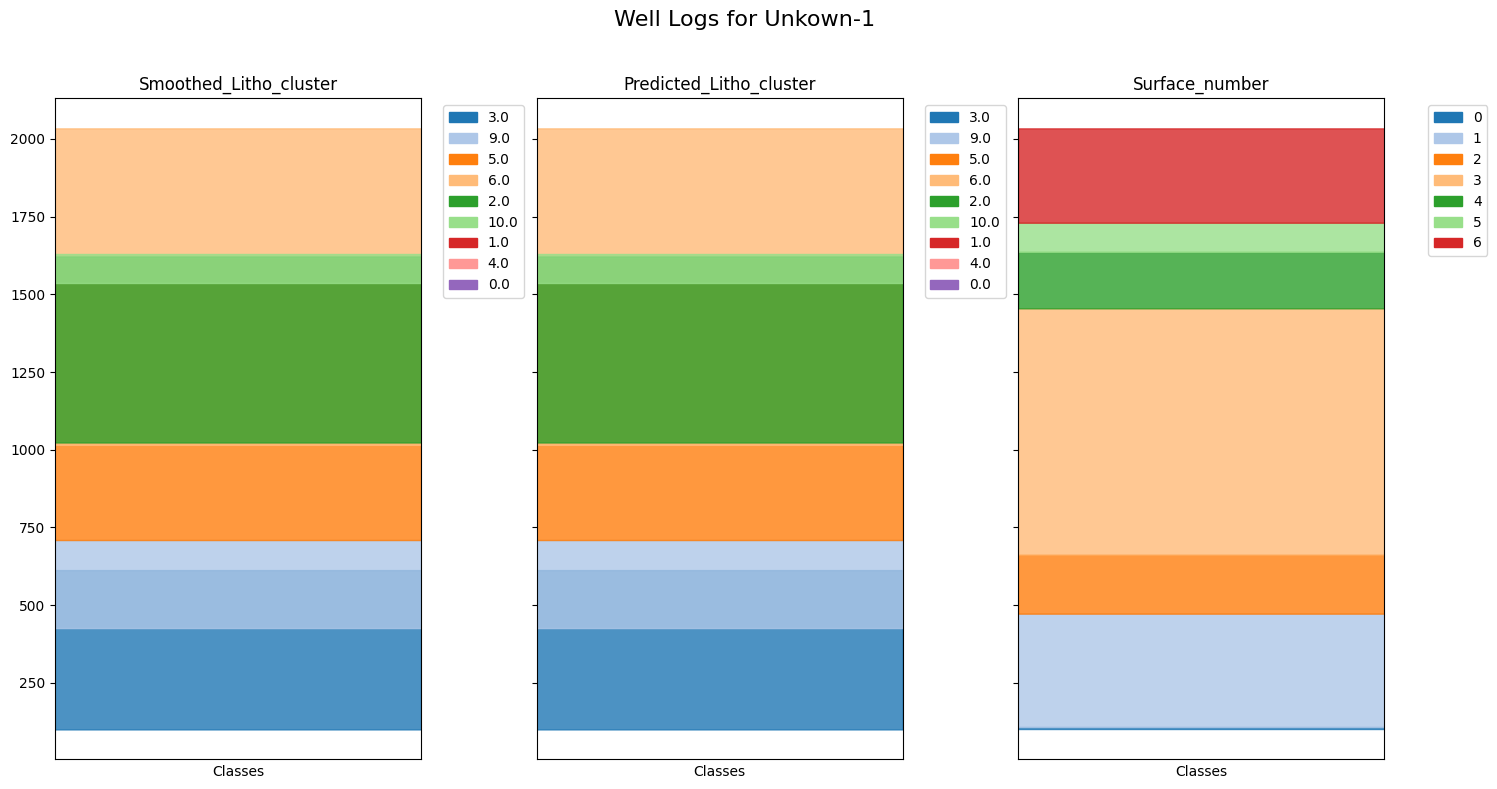

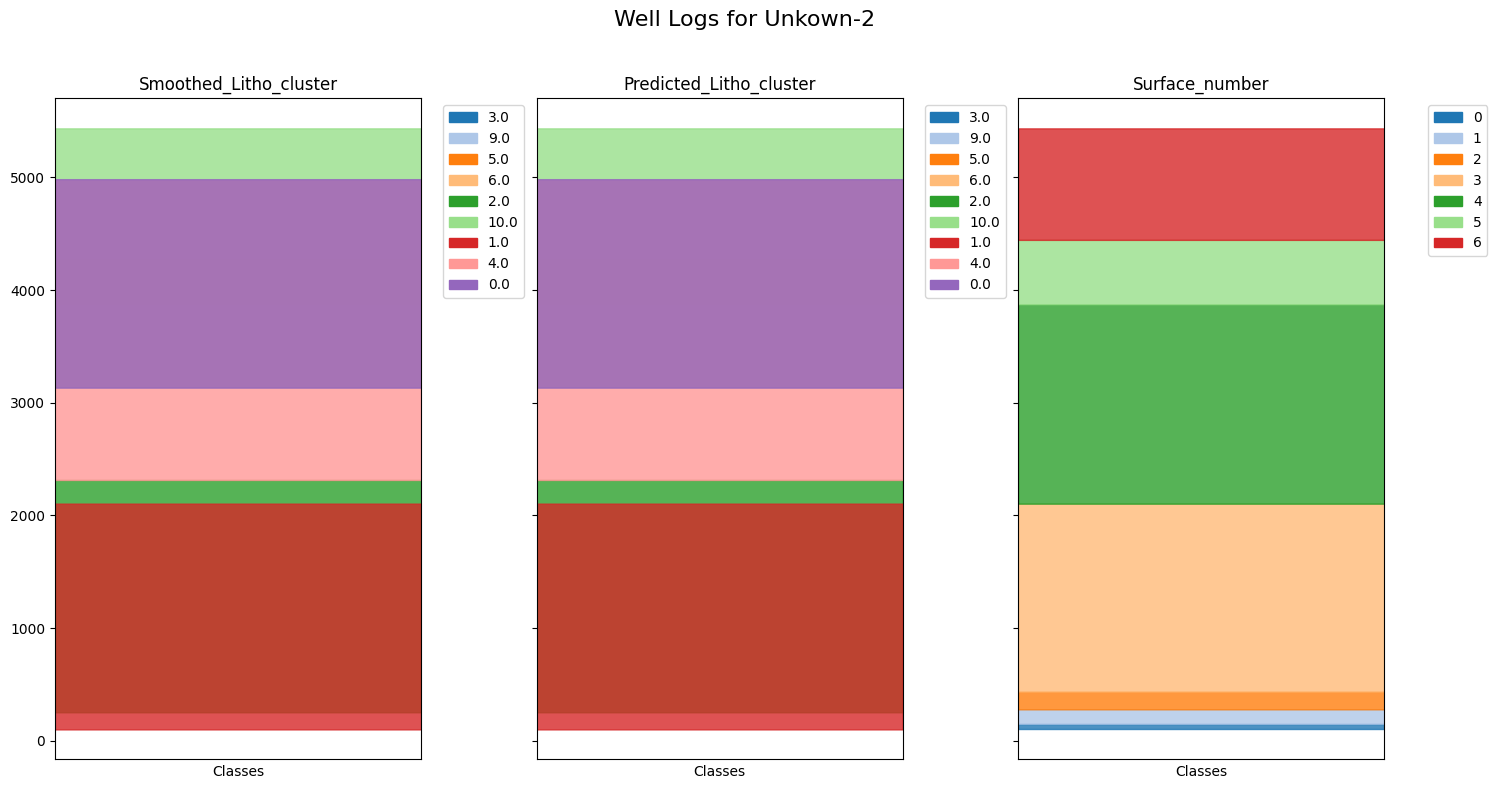

In [42]:
plot_logs_and_litho(Unknown_df, "Well_name", "Depth", [], ["Smoothed_Litho_cluster", "Predicted_Litho_cluster", "Surface_number"])

In [43]:
Unknown_df.to_csv("Predicted_Lith_Unknown.csv")

# 4. Train Gradient boosting

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.spatial.distance import cdist
from xgboost import callback

In [45]:
# Training Data (merged_df) and Test Data (unknown_df)
X_train = df_merged[['Depth', 'X', 'Y', 'Surface_number']].copy()
df_merged['Litho'] = df_merged['Litho'].astype(int)
y_train = df_merged['Litho']
X_test = Unknown_df[['Depth', 'X', 'Y', 'Surface_number']].copy()

In [47]:
train_coords = df_merged[['X', 'Y']].drop_duplicates().reset_index(drop=True)  # Unique training well coordinates
test_coords = Unknown_df[['X', 'Y']].drop_duplicates().reset_index(drop=True)  # Unique test well coordinates

# Compute distances between wells
distances = cdist(test_coords, train_coords)

# Assign minimum distances to each row in the test set
well_distance_map = pd.DataFrame({'X': test_coords['X'], 'Y': test_coords['Y'], 'Nearest_Well_Distance': distances.min(axis=1)})
X_test = X_test.merge(well_distance_map, on=['X', 'Y'], how='left')

# Assign a placeholder for training data (not used for training wells)
X_train['Nearest_Well_Distance'] = 0  # Placeholder (irrelevant for training)

# Normalize predictors (Depth, Surface_number, Nearest_Well_Distance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# Feature Engineering (Interaction Terms)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Train-Test Split for Validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_poly, y_train, test_size=0.2, random_state=42)

In [49]:
# Train XGBoost Model with Proximity Feature
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    n_iter_no_change=20
)


# Train the model with validation set and early stopping
xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=True,
)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:48:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_iter_no_change" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.98853
[1]	validation_0-mlogloss:1.73875
[2]	validation_0-mlogloss:1.55095
[3]	validation_0-mlogloss:1.40298
[4]	validation_0-mlogloss:1.28072
[5]	validation_0-mlogloss:1.17781
[6]	validation_0-mlogloss:1.08833
[7]	validation_0-mlogloss:1.01162
[8]	validation_0-mlogloss:0.94397
[9]	validation_0-mlogloss:0.88409
[10]	validation_0-mlogloss:0.83108
[11]	validation_0-mlogloss:0.78295
[12]	validation_0-mlogloss:0.74131
[13]	validation_0-mlogloss:0.70311
[14]	validation_0-mlogloss:0.66875
[15]	validation_0-mlogloss:0.63871
[16]	validation_0-mlogloss:0.61117
[17]	validation_0-mlogloss:0.58541
[18]	validation_0-mlogloss:0.56182
[19]	validation_0-mlogloss:0.54049
[20]	validation_0-mlogloss:0.52103
[21]	validation_0-mlogloss:0.50352
[22]	validation_0-mlogloss:0.48759
[23]	validation_0-mlogloss:0.47308
[24]	validation_0-mlogloss:0.45979
[25]	validation_0-mlogloss:0.44730
[26]	validation_0-mlogloss:0.43581
[27]	validation_0-mlogloss:0.42522
[28]	validation_0-mlogloss:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_iter_no_change=20,
              n_jobs=None, num_parallel_tree=None, ...)

In [50]:
# Predict Lithology for Test Data
y_test_pred = xgb_model.predict(X_test_poly)
Unknown_df['Predicted_Litho_XGB'] = y_test_pred

In [51]:
Unknown_df['Predicted_Litho_KNN'] = Unknown_df['Predicted_Litho_cluster']
Unknown_df = Unknown_df.drop('Predicted_Litho_cluster', axis = 1)

In [52]:
Unknown_df

,Well_name,X,Y,Depth,Surface_number,Smoothed_Litho_cluster,Predicted_Litho_XGB,Predicted_Litho_KNN
0,Unkown-1,683447.0,5072765.0,100.0,0,3.0,9,3.0
1,Unkown-1,683447.0,5072765.0,100.1,0,3.0,9,3.0
2,Unkown-1,683447.0,5072765.0,100.2,0,3.0,9,3.0
3,Unkown-1,683447.0,5072765.0,100.3,0,3.0,9,3.0
4,Unkown-1,683447.0,5072765.0,100.4,0,3.0,9,3.0
...,...,...,...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,6,10.0,0,10.0
72688,Unkown-2,691636.0,5072723.0,5434.7,6,10.0,0,10.0
72689,Unkown-2,691636.0,5072723.0,5434.8,6,10.0,0,10.0
72690,Unkown-2,691636.0,5072723.0,5434.9,6,10.0,0,10.0


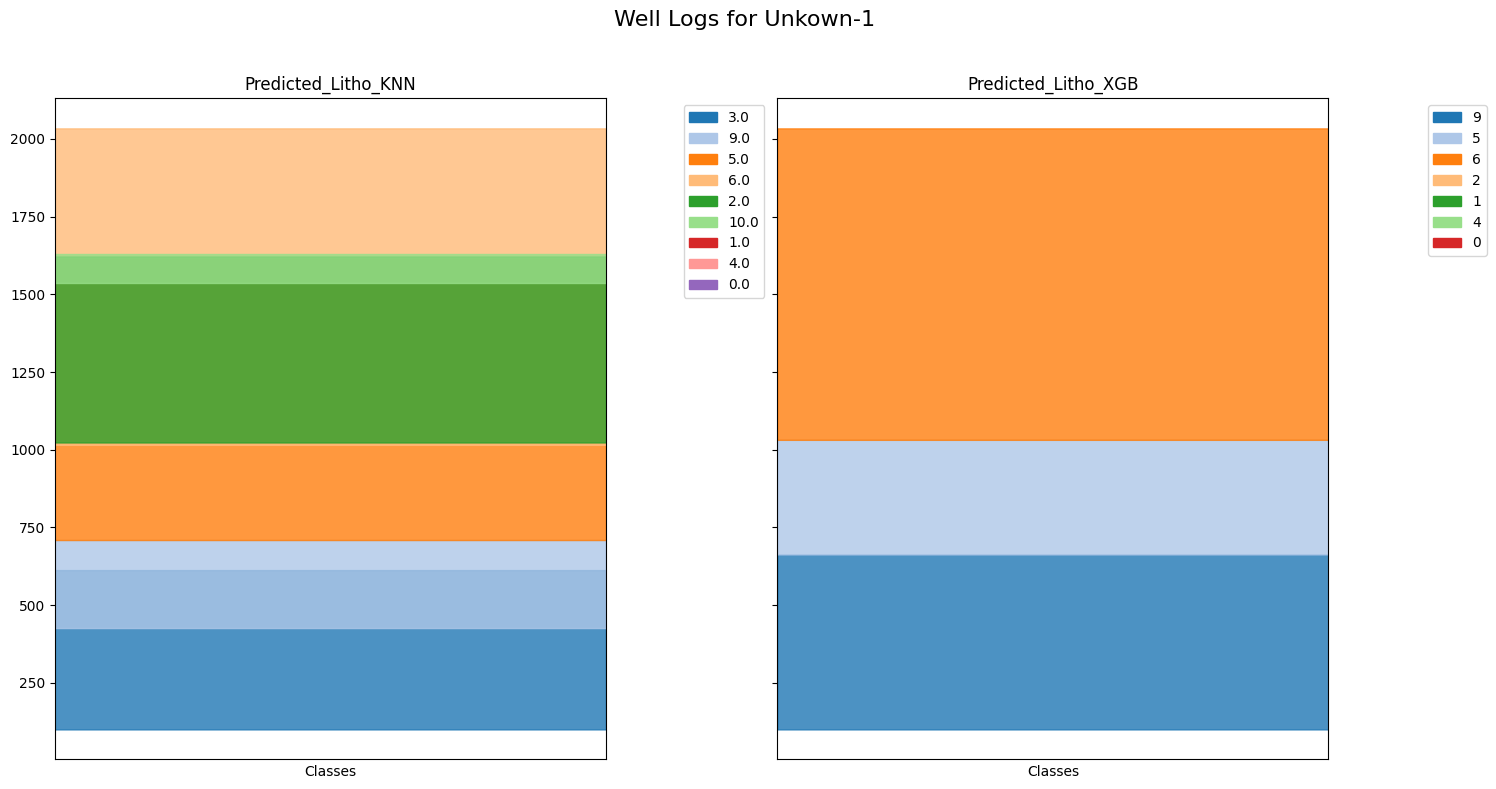

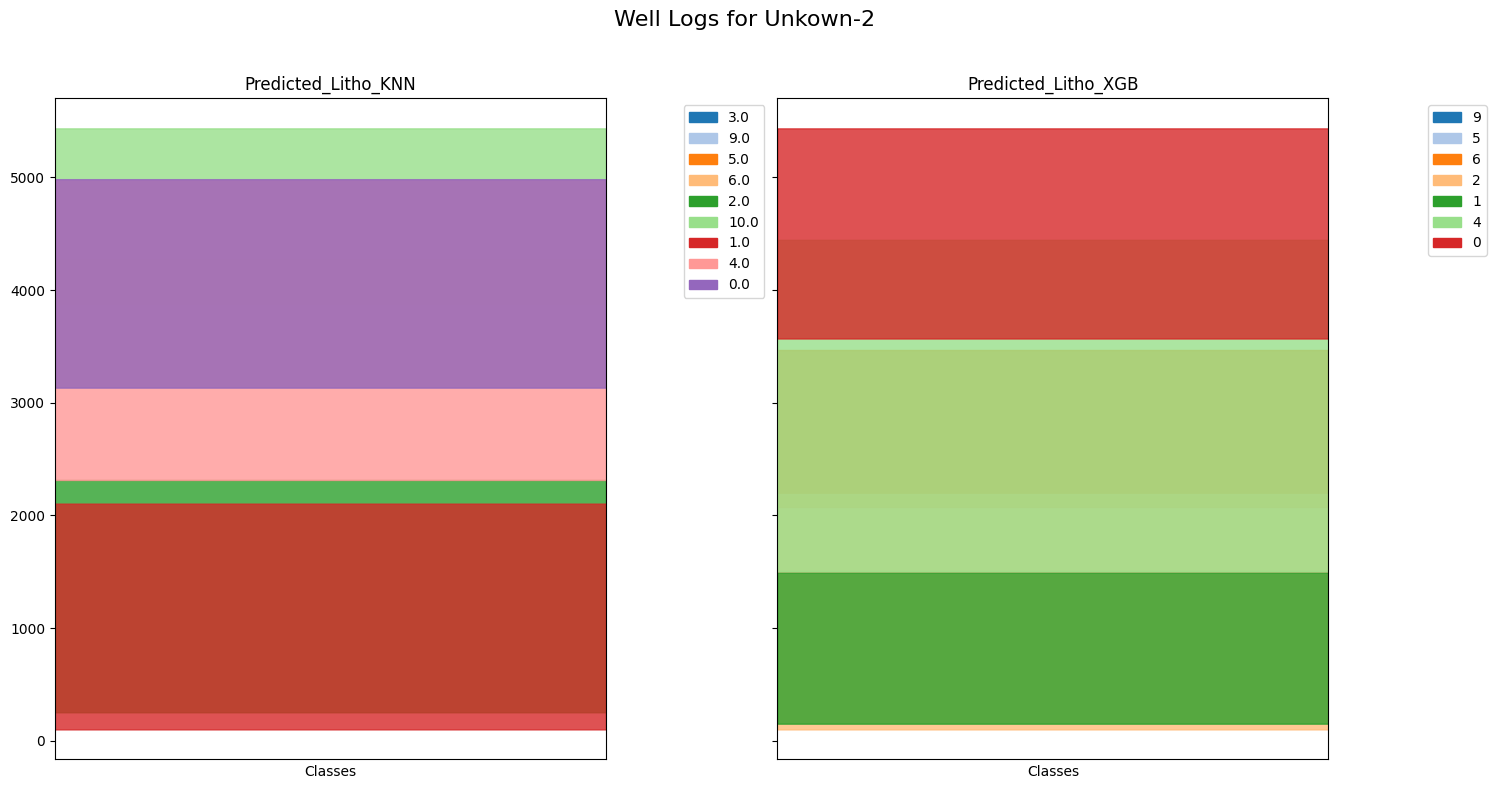

In [53]:
plot_logs_and_litho(Unknown_df, "Well_name", "Depth", [], ["Predicted_Litho_KNN", "Predicted_Litho_XGB"])

In [54]:
Unknown_df.to_csv("Litho_XGB_KNN.csv")

In [86]:
#Plot the columns with the depth incrising downwards
data = Unknown_df.sort_values(by='Depth')

In [89]:
Unknown_df['Depth_negative'] = Unknown_df['Depth'].apply(lambda x: -x)

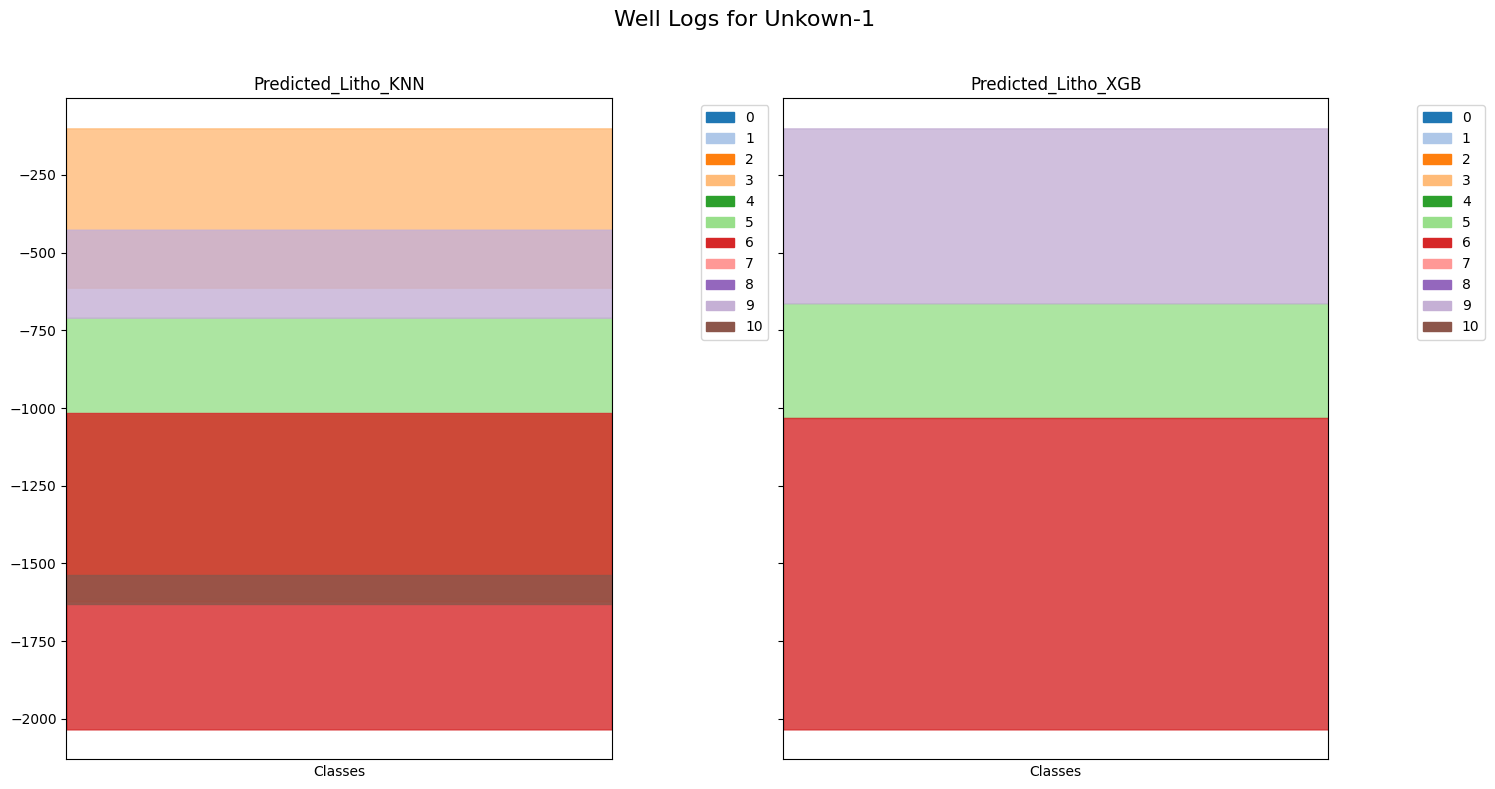

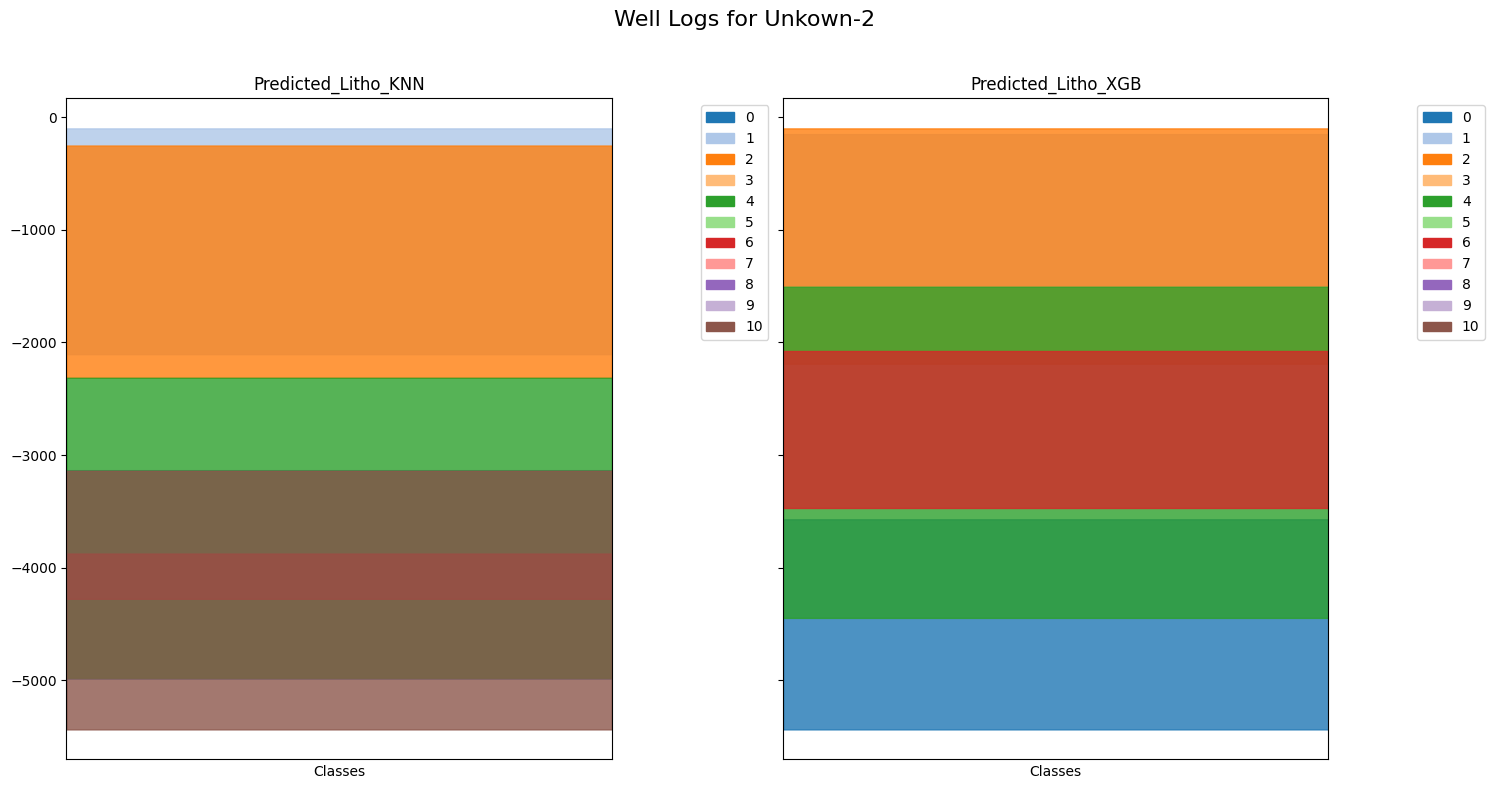

In [92]:
lithology_classes = [0,1,2,3,4,5,6,7,8,9,10]

plot_logs_and_litho(
    Unknown_df,
    "Well_name", "Depth_negative", [],
    ["Predicted_Litho_KNN", "Predicted_Litho_XGB"],
    lithology_classes=lithology_classes)



---



# 5. Adding statistics for porosity and permeability

In [58]:
Unknown_df

,Well_name,X,Y,Depth,Surface_number,Smoothed_Litho_cluster,Predicted_Litho_XGB,Predicted_Litho_KNN
0,Unkown-1,683447.0,5072765.0,100.0,0,3.0,9,3.0
1,Unkown-1,683447.0,5072765.0,100.1,0,3.0,9,3.0
2,Unkown-1,683447.0,5072765.0,100.2,0,3.0,9,3.0
3,Unkown-1,683447.0,5072765.0,100.3,0,3.0,9,3.0
4,Unkown-1,683447.0,5072765.0,100.4,0,3.0,9,3.0
...,...,...,...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,6,10.0,0,10.0
72688,Unkown-2,691636.0,5072723.0,5434.7,6,10.0,0,10.0
72689,Unkown-2,691636.0,5072723.0,5434.8,6,10.0,0,10.0
72690,Unkown-2,691636.0,5072723.0,5434.9,6,10.0,0,10.0


In [63]:
Unknown_df["Litho"]=Unknown_df["Predicted_Litho_KNN"]

In [61]:
Statistics = pd.read_csv("/content/Statistics_by_cluster.csv")

In [62]:
Statistics

,KMeans,VSHALE_max,VSHALE_min,VSHALE_mean,VSHALE_std,PHIT_max,PHIT_min,PHIT_mean,PHIT_std,PHIE_max,PHIE_min,PHIE_mean,PHIE_std,PERM_max,PERM_min,PERM_mean,PERM_std
0,0,1.000000,0.000000,0.397974,0.229182,0.552407,0.000000,0.106160,0.044739,0.277863,0.000000,0.031327,0.039702,569.691223,0.000000,0.846018,12.450989
1,1,0.300738,0.000000,0.121352,0.097955,0.225517,0.000000,0.023096,0.035138,0.438873,0.000000,0.024294,0.093896,9.336400,0.000000,1.867300,4.175354
2,2,0.633489,0.000000,0.262805,0.165035,0.477931,0.000000,0.184482,0.057880,0.456002,0.000000,0.130741,0.068783,299.546814,0.000000,5.268468,19.536399
3,3,1.000000,0.173192,0.773380,0.161716,0.500420,0.030005,0.212371,0.135676,0.388724,0.153252,0.297953,0.074247,483.126862,0.000100,79.650455,159.614259
4,4,0.948501,0.000000,0.313680,0.181049,0.328423,0.000000,0.087519,0.063598,0.256423,0.000000,0.038320,0.047344,53.304920,0.000000,0.499455,1.972914
5,5,0.999724,0.000000,0.578661,0.175713,0.582303,0.043550,0.321513,0.082063,0.442449,0.000000,0.195971,0.091662,419.183105,0.000000,50.195320,74.256516
6,6,1.000000,0.234434,0.823631,0.145877,0.377242,0.000000,0.153527,0.041744,0.225237,0.000000,0.030641,0.030035,21.806391,0.000000,0.099196,0.606392
7,7,0.984670,0.000000,0.314823,0.162113,0.694220,0.000000,0.146031,0.178137,0.501000,0.000000,0.040679,0.094685,451.297089,0.000000,32.090938,66.431879
8,8,0.799319,0.019837,0.234484,0.257362,1.000000,0.663591,0.835770,0.119259,0.704003,0.376522,0.539495,0.078788,11158.969727,3126.333008,5623.201540,1734.961653
9,9,0.966793,0.000000,0.429618,0.226698,0.829942,0.363048,0.476844,0.073424,0.637380,0.021353,0.436399,0.067860,3061.397949,139.385895,632.501247,347.741077


In [64]:
Statistics["Litho"] = Statistics["KMeans"]

In [65]:
# Merge the DataFrames on 'clusters'
Unknown_properties = Unknown_df.merge(Statistics, on='Litho', how='left')

In [71]:
#Drop the unnecessary columns
Unknown_properties = Unknown_properties.drop(["Smoothed_Litho_cluster", "Predicted_Litho_XGB", "KMeans", "Predicted_Litho_KNN"], axis=1)

In [75]:
#Round the values in statistics up to 3 signs after the coma
initial_cols = Unknown_properties.iloc[:, :7]
rounded_cols = Unknown_properties.iloc[:, 7:].round(3)
Unknown_result = pd.concat([initial_cols, rounded_cols], axis=1)

In [76]:
Unknown_result

,Well_name,X,Y,Depth,Surface_number,Litho,VSHALE_max,VSHALE_min,VSHALE_mean,VSHALE_std,...,PHIT_mean,PHIT_std,PHIE_max,PHIE_min,PHIE_mean,PHIE_std,PERM_max,PERM_min,PERM_mean,PERM_std
0,Unkown-1,683447.0,5072765.0,100.0,0,3.0,1.0,0.173,0.773,0.162,...,0.212,0.136,0.389,0.153,0.298,0.074,483.127,0.0,79.650,159.614
1,Unkown-1,683447.0,5072765.0,100.1,0,3.0,1.0,0.173,0.773,0.162,...,0.212,0.136,0.389,0.153,0.298,0.074,483.127,0.0,79.650,159.614
2,Unkown-1,683447.0,5072765.0,100.2,0,3.0,1.0,0.173,0.773,0.162,...,0.212,0.136,0.389,0.153,0.298,0.074,483.127,0.0,79.650,159.614
3,Unkown-1,683447.0,5072765.0,100.3,0,3.0,1.0,0.173,0.773,0.162,...,0.212,0.136,0.389,0.153,0.298,0.074,483.127,0.0,79.650,159.614
4,Unkown-1,683447.0,5072765.0,100.4,0,3.0,1.0,0.173,0.773,0.162,...,0.212,0.136,0.389,0.153,0.298,0.074,483.127,0.0,79.650,159.614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72687,Unkown-2,691636.0,5072723.0,5434.6,6,10.0,1.0,0.000,0.646,0.198,...,0.159,0.041,0.283,0.000,0.034,0.041,419.278,0.0,0.688,5.794
72688,Unkown-2,691636.0,5072723.0,5434.7,6,10.0,1.0,0.000,0.646,0.198,...,0.159,0.041,0.283,0.000,0.034,0.041,419.278,0.0,0.688,5.794
72689,Unkown-2,691636.0,5072723.0,5434.8,6,10.0,1.0,0.000,0.646,0.198,...,0.159,0.041,0.283,0.000,0.034,0.041,419.278,0.0,0.688,5.794
72690,Unkown-2,691636.0,5072723.0,5434.9,6,10.0,1.0,0.000,0.646,0.198,...,0.159,0.041,0.283,0.000,0.034,0.041,419.278,0.0,0.688,5.794


In [77]:
Unknown_result.to_csv("Unknown_wells_result.csv")



---

